In [1]:
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import silhouette_score, mean_absolute_error
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor

In [2]:
glbInd = pd.read_csv("Global Health Indicators Dataset.zip")
glbInd.head()

,country,country_code,year,health_exp,life_expect,maternal_mortality,infant_mortality,neonatal_mortality,under_5_mortality,prev_hiv,inci_tuberc,prev_undernourishment
0,Aruba,ABW,1999,NaN,73.561000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,1999,NaN,51.258874,NaN,88.285642,38.433841,142.506373,6.684793,NaN,NaN
2,Afghanistan,AFG,1999,NaN,54.846000,NaN,94.600000,64.000000,135.800000,0.100000,NaN,NaN
3,Africa Western and Central,AFW,1999,NaN,49.726429,NaN,101.541373,44.733554,173.943151,NaN,NaN,NaN
4,Angola,AGO,1999,NaN,45.386000,NaN,123.500000,51.000000,208.000000,1.300000,NaN,NaN


In [3]:
glbInd.drop(columns = ["country_code"], inplace = True)


for column in glbInd.columns:
    mode_value = glbInd[column].mode().iloc[0]
    glbInd[column] = glbInd[column].fillna(mode_value)
glbInd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                6650 non-null   object 
 1   year                   6650 non-null   int64  
 2   health_exp             6650 non-null   float64
 3   life_expect            6650 non-null   float64
 4   maternal_mortality     6650 non-null   float64
 5   infant_mortality       6650 non-null   float64
 6   neonatal_mortality     6650 non-null   float64
 7   under_5_mortality      6650 non-null   float64
 8   prev_hiv               6650 non-null   float64
 9   inci_tuberc            6650 non-null   float64
 10  prev_undernourishment  6650 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 571.6+ KB


In [4]:
# Regions (mapped directly to their broader continent)
not_Country = ["American Samoa", "Curacao", "Caribbean small states", "Channel Islands", "Cayman Islands", 
               "Early-demographic dividend", "Faroe Islands", "Gibraltar", "Guam", "Hong Kong SAR, China", 
               "Heavily indebted poor countries (HIPC)", "IBRD only", "IDA only", "Isle of Man", "Not classified", 
               "Latin America & Caribbean (excluding high income)", "Lao PDR", "Least developed countries: UN classification", 
               "Low income", "Lower middle income", "Late-demographic dividend", "Macao SAR, China", "St. Martin (French part)", 
               "Middle income", "Northern Mariana Islands", "New Caledonia", "OECD members", "Pre-demographic dividend", "Puerto Rico", 
               "Korea, Dem. People's Rep.", "West Bank and Gaza", "Post-demographic dividend", "French Polynesia", "South Asia", 
               "Sub-Saharan Africa (excluding high income)", "Sint Maarten (Dutch part)", "Syrian Arab Republic", "Turks and Caicos Islands", 
               "East Asia & Pacific (IDA & IBRD countries)", "Europe & Central Asia (IDA & IBRD countries)", 
               "Latin America & the Caribbean (IDA & IBRD countries)", "Middle East & North Africa (IDA & IBRD countries)", 
               "South Asia (IDA & IBRD)", "Sub-Saharan Africa (IDA & IBRD countries)", "Turkiye", "Upper middle income", 
               "British Virgin Islands", "Virgin Islands (U.S.)", "Kosovo", "Africa Eastern and Southern", "Africa Western and Central", 
               "Arab World", "Central Europe and the Baltics", "East Asia & Pacific (excluding high income)", "East Asia & Pacific", 
               "Europe & Central Asia (excluding high income)", "Europe & Central Asia", "Euro area", "European Union", 
               "Fragile and conflict affected situations", "High income", "IDA & IBRD total", "IDA total", "IDA blend", 
               "Latin America & Caribbean", "Low & middle income", "Middle East & North Africa", "Middle East & North Africa (excluding high income)", 
               "North America", "Other small states", "Pacific island small states", "Small states", "Sub-Saharan Africa", "World", "Greenland"
              ]

# Filter out rows where 'country' is in the 'not_Country' list
glbInd = glbInd[~glbInd["country"].isin(not_Country)]

# Check the updated DataFrame information
glbInd.head()

,country,year,health_exp,life_expect,maternal_mortality,infant_mortality,neonatal_mortality,under_5_mortality,prev_hiv,inci_tuberc,prev_undernourishment
0,Aruba,1999,5.08,73.561000,5.0,3.3,2.3,4.1,0.1,12.0,2.5
2,Afghanistan,1999,5.08,54.846000,5.0,94.6,64.0,135.8,0.1,12.0,2.5
4,Angola,1999,5.08,45.386000,5.0,123.5,51.0,208.0,1.3,12.0,2.5
5,Albania,1999,5.08,75.183000,5.0,25.2,12.2,28.5,0.1,12.0,2.5
6,Andorra,1999,5.08,81.404878,5.0,6.8,3.7,8.0,0.1,12.0,2.5


In [5]:
continent_dict = {
    # Countries
    'Aruba': 'North America', 'Afghanistan': 'Asia', 'Angola': 'Africa', 'Albania': 'Europe', 'Andorra': 'Europe',
    'United Arab Emirates': 'Asia', 'Argentina': 'South America', 'Armenia': 'Asia',
    'Antigua and Barbuda': 'North America', 'Australia': 'Oceania', 'Austria': 'Europe', 'Azerbaijan': 'Asia',
    'Burundi': 'Africa', 'Belgium': 'Europe', 'Benin': 'Africa', 'Burkina Faso': 'Africa', 'Bangladesh': 'Asia',
    'Bulgaria': 'Europe', 'Bahrain': 'Asia', 'Bahamas, The': 'North America', 'Bosnia and Herzegovina': 'Europe',
    'Belarus': 'Europe', 'Belize': 'North America', 'Bermuda': 'North America', 'Bolivia': 'South America',
    'Brazil': 'South America', 'Barbados': 'North America', 'Brunei Darussalam': 'Asia', 'Bhutan': 'Asia',
    'Botswana': 'Africa', 'Central African Republic': 'Africa', 'Canada': 'North America', 'Switzerland': 'Europe',
    'Chile': 'South America', 'China': 'Asia', "Cote d'Ivoire": 'Africa', 'Cameroon': 'Africa', 'Congo, Dem. Rep.': 'Africa',
    'Congo, Rep.': 'Africa', 'Colombia': 'South America', 'Comoros': 'Africa', 'Cabo Verde': 'Africa', 'Costa Rica': 'North America',
    'Cuba': 'North America', 'Curacao': 'North America', 'Cayman Islands': 'North America', 'Cyprus': 'Asia',
    'Czechia': 'Europe', 'Germany': 'Europe', 'Djibouti': 'Africa', 'Dominica': 'North America', 'Denmark': 'Europe',
    'Dominican Republic': 'North America', 'Algeria': 'Africa', 'Ecuador': 'South America', 'Egypt, Arab Rep.': 'Africa',
    'Estonia': 'Europe', 'Ethiopia': 'Africa', 'Finland': 'Europe', 'Fiji': 'Oceania', 'France': 'Europe', 
    'Gabon': 'Africa', 'United Kingdom': 'Europe', 'Georgia': 'Asia', 'Ghana': 'Africa', 'Greece': 'Europe', 
    'Grenada': 'North America', 'Guatemala': 'North America', 'Guyana': 'South America', 'Honduras': 'North America', 
    'Hungary': 'Europe', 'Indonesia': 'Asia', 'India': 'Asia', 'Ireland': 'Europe', 'Iran, Islamic Rep.': 'Asia',
    'Iraq': 'Asia', 'Iceland': 'Europe', 'Israel': 'Asia', 'Italy': 'Europe', 'Jamaica': 'North America', 
    'Jordan': 'Asia', 'Japan': 'Asia', 'Kazakhstan': 'Asia', 'Kenya': 'Africa', 'Kyrgyz Republic': 'Asia', 
    'Cambodia': 'Asia', 'Kiribati': 'Oceania', 'St. Kitts and Nevis': 'North America', 'Korea, Rep.': 'Asia', 
    'Kuwait': 'Asia', 'Latvia': 'Europe', 'Lebanon': 'Asia', 'Liberia': 'Africa', 'Libya': 'Africa', 'Lithuania': 'Europe',
    'Luxembourg': 'Europe', 'Macedonia': 'Europe', 'Madagascar': 'Africa', 'Malaysia': 'Asia', 'Malta': 'Europe',
    'Mexico': 'North America', 'Moldova': 'Europe', 'Monaco': 'Europe', 'Mozambique': 'Africa', 'Mauritius': 'Africa',
    'Malawi': 'Africa', 'Maldives': 'Asia', 'Mali': 'Africa', 'Morocco': 'Africa', 'Mauritania': 'Africa', 
    'Montenegro': 'Europe', 'Mozambique': 'Africa', 'Myanmar': 'Asia', 'Namibia': 'Africa', 'Nicaragua': 'North America',
    'Netherlands': 'Europe', 'Nepal': 'Asia', 'New Zealand': 'Oceania', 'Nigeria': 'Africa', 'Norway': 'Europe', 
    'Pakistan': 'Asia', 'Palau': 'Oceania', 'Panama': 'North America', 'Peru': 'South America', 'Philippines': 'Asia', 
    'Poland': 'Europe', 'Portugal': 'Europe', 'Romania': 'Europe', 'Russia': 'Europe', 'Rwanda': 'Africa', 
    'Saudi Arabia': 'Asia', 'Senegal': 'Africa', 'Singapore': 'Asia', 'Slovenia': 'Europe', 'South Africa': 'Africa', 
    'South Korea': 'Asia', 'Sri Lanka': 'Asia', 'Sudan': 'Africa', 'Sweden': 'Europe', 'Switzerland': 'Europe', 
    'Syria': 'Asia', 'Taiwan': 'Asia', 'Tanzania': 'Africa', 'Thailand': 'Asia', 'Trinidad and Tobago': 'North America', 
    'Tunisia': 'Africa', 'Turkey': 'Asia', 'Uganda': 'Africa', 'Ukraine': 'Europe', 'United States': 'North America', 
    'Uzbekistan': 'Asia', 'Venezuela': 'South America', 'Vietnam': 'Asia', 'Yemen': 'Asia', 'Zambia': 'Africa', 
    'Zimbabwe': 'Africa', 'Eritrea': 'Africa', 'Spain': 'Europe', 'Micronesia, Fed. Sts.': 'Oceania', 'Guinea': 'Africa', 'Gambia, The': 'Africa',
    'Guinea-Bissau': 'Africa', 'Equatorial Guinea': 'Africa', 'Croatia': 'Europe', 'Haiti': 'North America', 'St. Lucia': 'North America', 
    'Liechtenstein': 'Europe', 'Lesotho': 'Africa', 'Marshall Islands': 'Oceania', 'North Macedonia': 'Europe', 'Mongolia': 'Asia', 'Niger': 'Africa', 
    'Nauru': 'Oceania', 'Oman': 'Asia', 'Papua New Guinea': 'Oceania', 'Paraguay': 'South America', 'Qatar': 'Asia',
    'Russian Federation': 'Asia', 'Solomon Islands': 'Oceania', 'Sierra Leone': 'Africa', 'El Salvador': 'North America', 'San Marino': 'Europe',
    'Somalia': 'Africa', 'Serbia': 'Europe', 'South Sudan': 'Africa', 'Sao Tome and Principe': 'Africa', 'Suriname': 'South America', 
    'Slovak Republic': 'Europe', 'Eswatini': 'Africa', 'Seychelles': 'Africa', 'Chad': 'Africa', 'Togo': 'Africa', 'Tajikistan': 'Asia',
    'Turkmenistan': 'Asia', 'Timor-Leste': 'Asia', 'Tonga': 'Oceania', 'Tuvalu': 'Oceania', 'Uruguay': 'South America', 
    'St. Vincent and the Grenadines': 'North America', 'Venezuela, RB': 'South America', 'Viet Nam': 'Asia', 'Vanuatu': 'Oceania', 'Samoa': 'Oceania',
    'Yemen, Rep.': 'Asia'
}


# Assign continent based on the continent_dict
glbInd["continent"] = glbInd["country"].map(continent_dict)


glbInd.head()

,country,year,health_exp,life_expect,maternal_mortality,infant_mortality,neonatal_mortality,under_5_mortality,prev_hiv,inci_tuberc,prev_undernourishment,continent
0,Aruba,1999,5.08,73.561000,5.0,3.3,2.3,4.1,0.1,12.0,2.5,North America
2,Afghanistan,1999,5.08,54.846000,5.0,94.6,64.0,135.8,0.1,12.0,2.5,Asia
4,Angola,1999,5.08,45.386000,5.0,123.5,51.0,208.0,1.3,12.0,2.5,Africa
5,Albania,1999,5.08,75.183000,5.0,25.2,12.2,28.5,0.1,12.0,2.5,Europe
6,Andorra,1999,5.08,81.404878,5.0,6.8,3.7,8.0,0.1,12.0,2.5,Europe


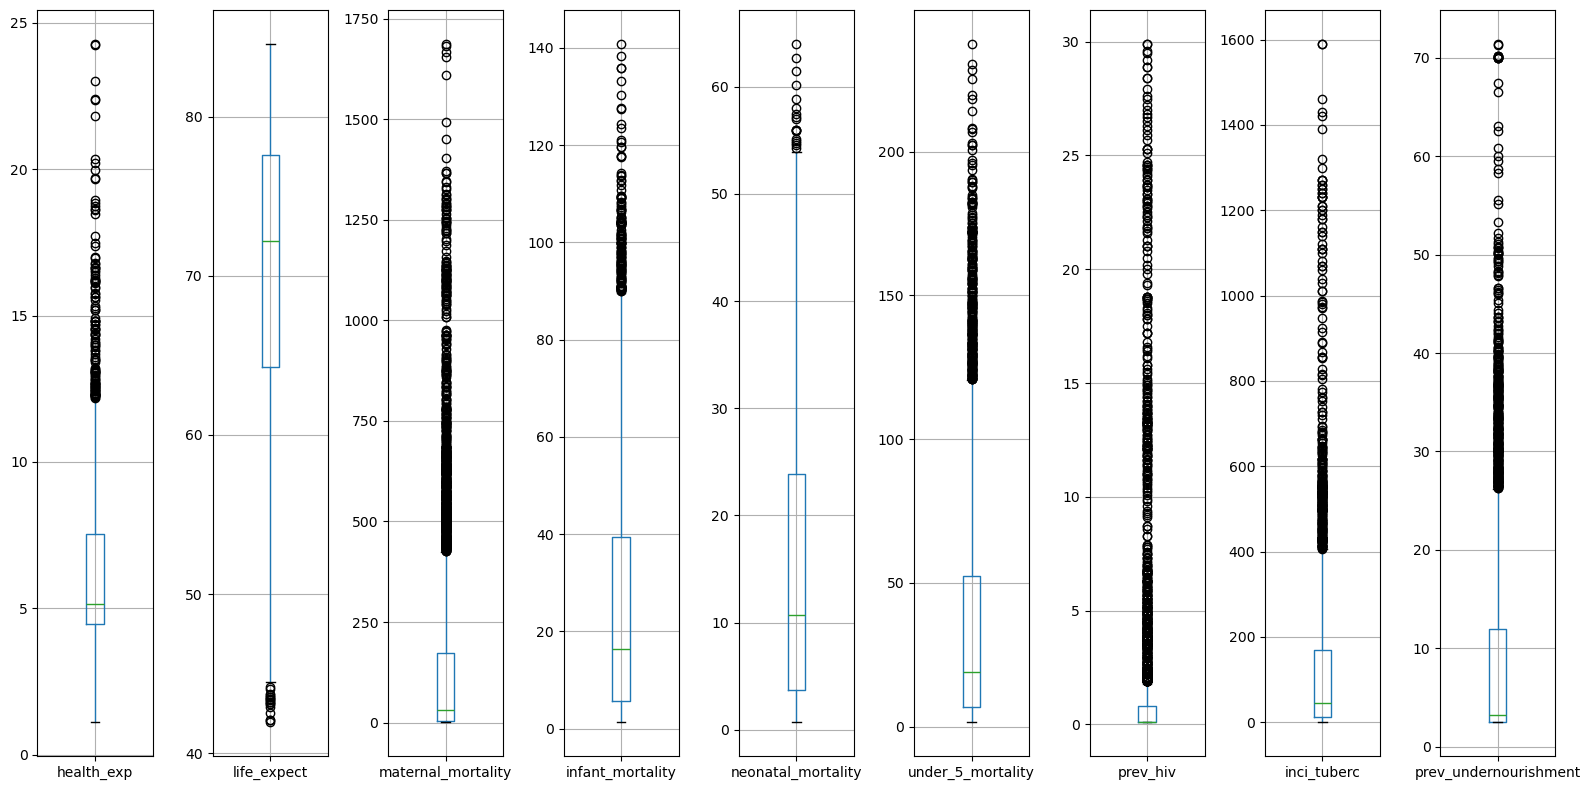

In [6]:
# Extract features
glbIndNum = glbInd.select_dtypes(["float", "int"])
glbInd_new = glbIndNum.drop(columns = "year")

# Box plot for Numerical Features

# Create subplots
fig, ax = plt.subplots(1, len(glbInd_new.columns), figsize=(16, 8))

# Plot a boxplot for each column
for i, col in enumerate(glbInd_new.columns):
    glbInd_new.boxplot(column = col, ax = ax[i])

plt.tight_layout()
plt.show()

In [7]:
matMask = glbInd["maternal_mortality"] < 1500
tuberMask = glbInd["inci_tuberc"] < 1500
glbInd = glbInd[matMask & tuberMask]
glbInd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4768 entries, 0 to 6649
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                4768 non-null   object 
 1   year                   4768 non-null   int64  
 2   health_exp             4768 non-null   float64
 3   life_expect            4768 non-null   float64
 4   maternal_mortality     4768 non-null   float64
 5   infant_mortality       4768 non-null   float64
 6   neonatal_mortality     4768 non-null   float64
 7   under_5_mortality      4768 non-null   float64
 8   prev_hiv               4768 non-null   float64
 9   inci_tuberc            4768 non-null   float64
 10  prev_undernourishment  4768 non-null   float64
 11  continent              4768 non-null   object 
dtypes: float64(9), int64(1), object(2)
memory usage: 484.2+ KB


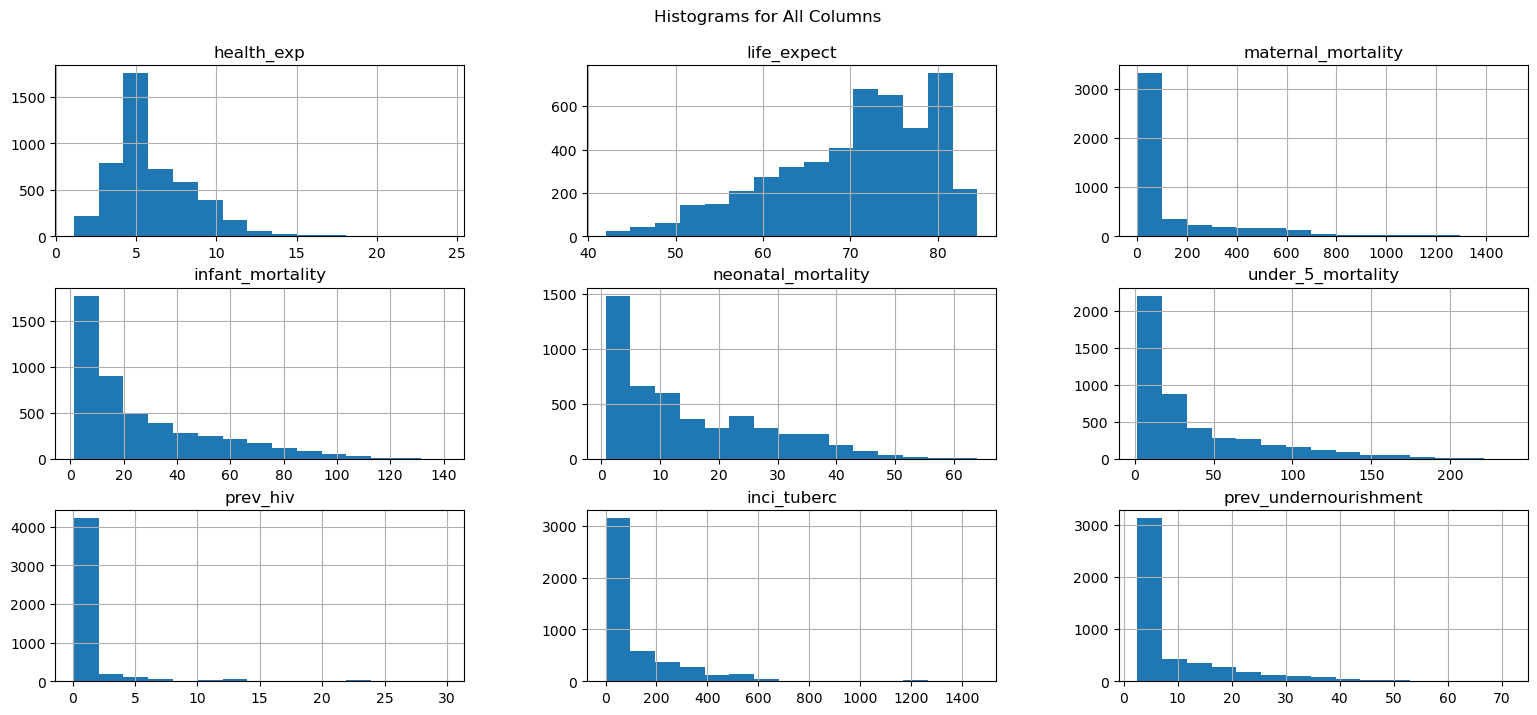

In [8]:
# Drop the 'year' column and plot histograms for remaining columns
glbInd.drop(columns="year").hist(bins = 15, figsize=(19, 8))
plt.suptitle("Histograms for All Columns", y=0.95)
plt.show()

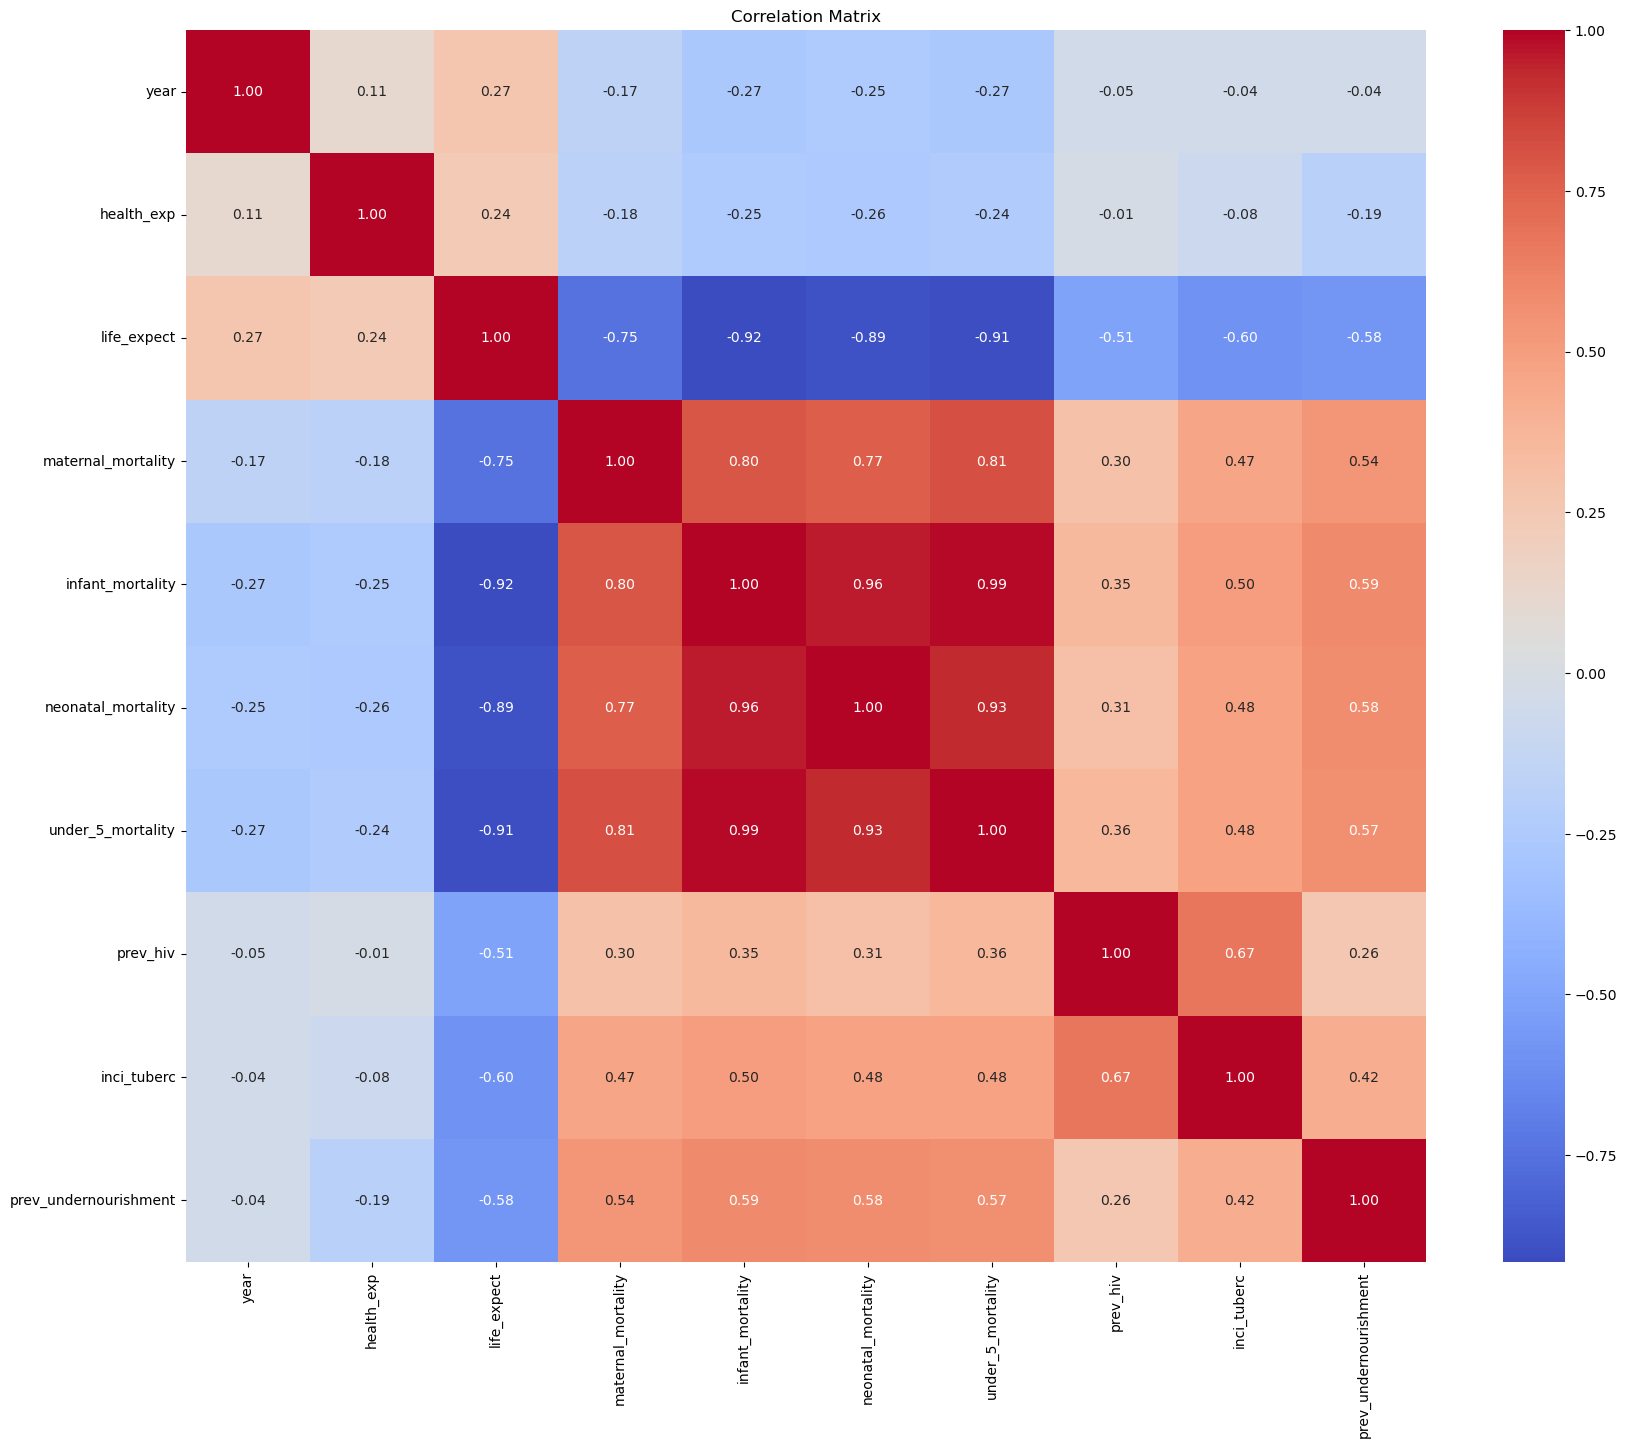

In [9]:
# Plot the correlation matrix of the main numerical features
plt.subplots(figsize=(20, 16))

sns.heatmap(glbIndNum.corr(), annot=True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation Matrix");

In [10]:
# Get the summary of the data set
glbInd.drop(columns = "year").describe()

,health_exp,life_expect,maternal_mortality,infant_mortality,neonatal_mortality,under_5_mortality,prev_hiv,inci_tuberc,prev_undernourishment
count,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000
mean,6.096002,70.396625,150.137374,26.251279,14.856732,36.526909,1.374098,124.173257,8.909312
std,2.655793,9.084665,250.080072,25.688526,12.734987,40.965106,3.772548,184.204176,10.402525
min,1.107200,41.957000,1.000000,1.300000,0.700000,1.500000,0.100000,0.000000,2.500000
25%,4.458582,64.320000,5.000000,5.600000,3.600000,6.700000,0.100000,12.000000,2.500000
50%,5.141524,72.184000,32.000000,16.400000,10.700000,19.100000,0.100000,46.000000,3.200000
75%,7.540000,77.584250,172.000000,39.200000,23.900000,52.100000,0.800000,169.000000,12.000000
max,24.283052,84.560000,1493.000000,140.800000,64.000000,237.500000,29.900000,1460.000000,71.400000


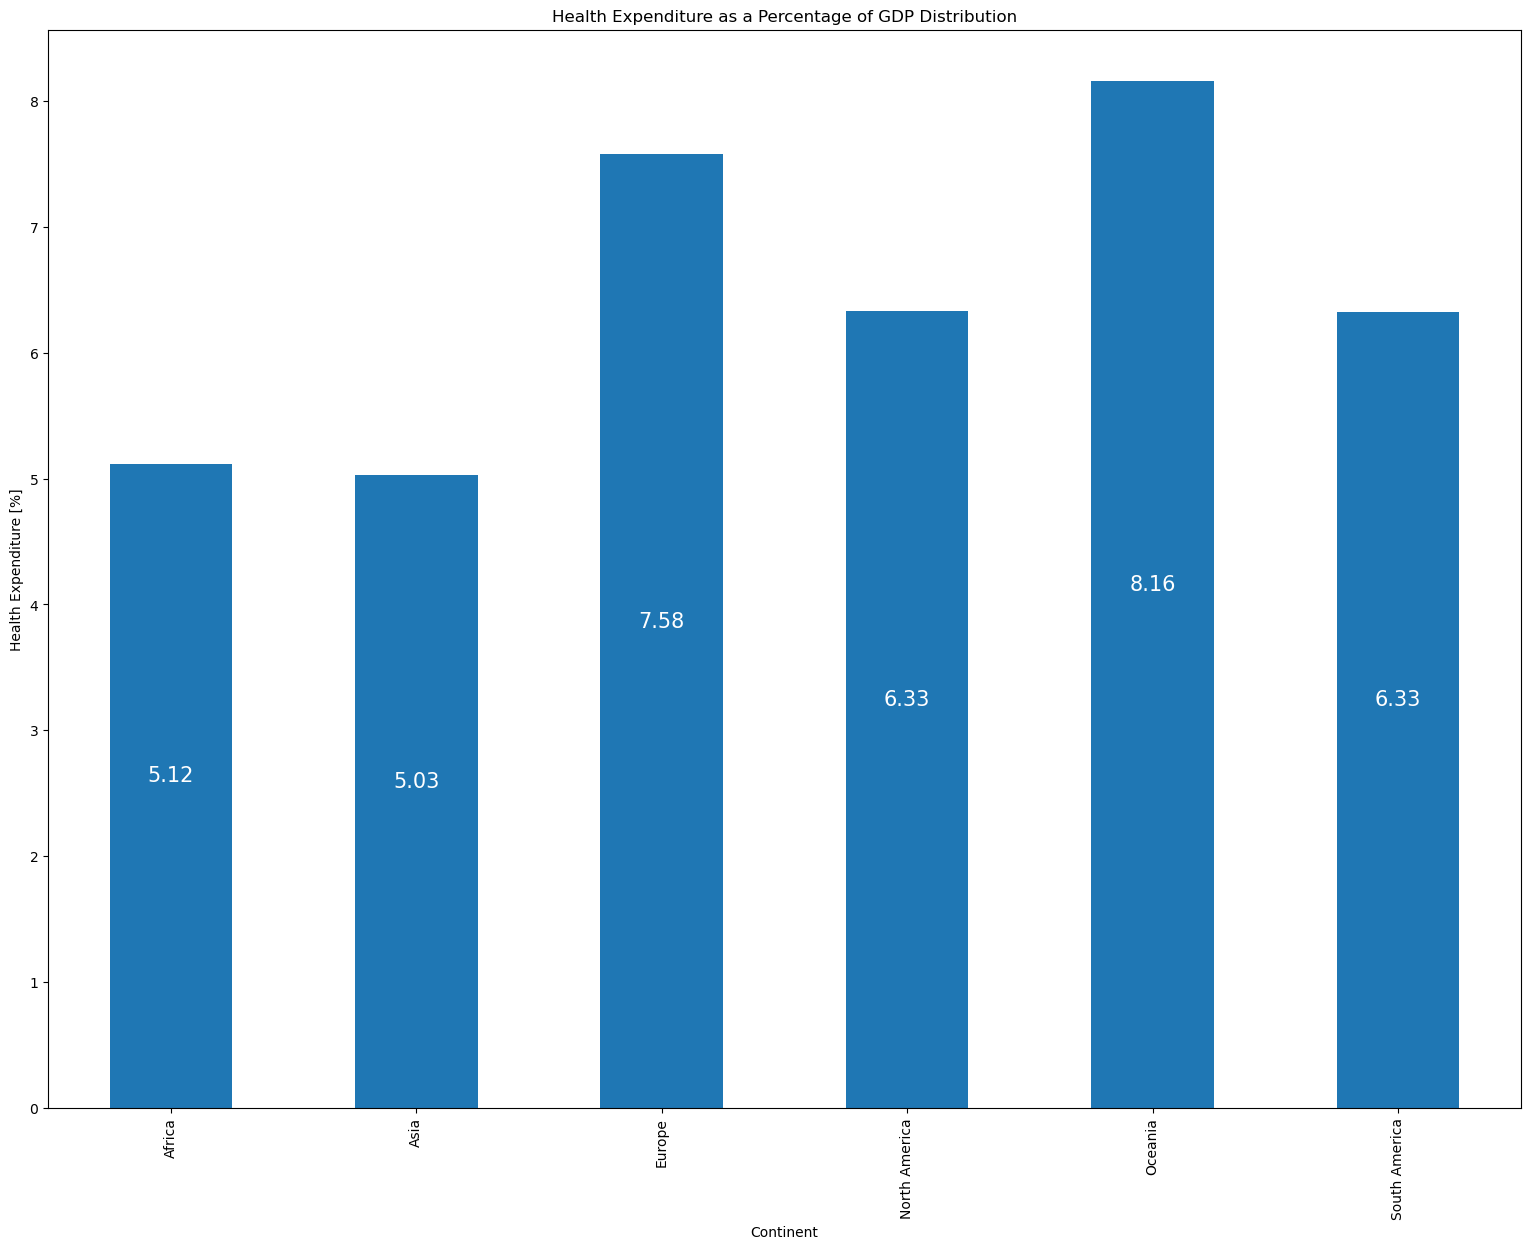

In [11]:
# Plot the distribution of health expenditure across continents
ax = glbInd.groupby("continent")["health_exp"].mean().plot(
    kind="bar",
    ylabel="Health Expenditure [%]",
    xlabel="Continent",
    title="Health Expenditure as a Percentage of GDP Distribution",
    figsize=(19, 14)
)

# Annotate each bar with its height
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate of text
        height/2,  # Y-coordinate of text
        f'{height:.2f}',  # Format the height value
        ha = "center",  # Horizontal alignment
        va = "bottom",  # Vertical alignment
        fontsize = 15,  # Font size
        color = "white"  # Text color
    )

plt.show()

In [12]:
# Compare health metrics between continents
continental_avg = glbInd.groupby("continent")[["health_exp", "life_expect"]].mean()
continental_avg

,health_exp,life_expect
continent,,
Africa,5.117437,60.580411
Asia,5.025071,72.447141
Europe,7.576378,78.003557
North America,6.330250,73.881374
Oceania,8.159510,70.360543
South America,6.326698,72.979922


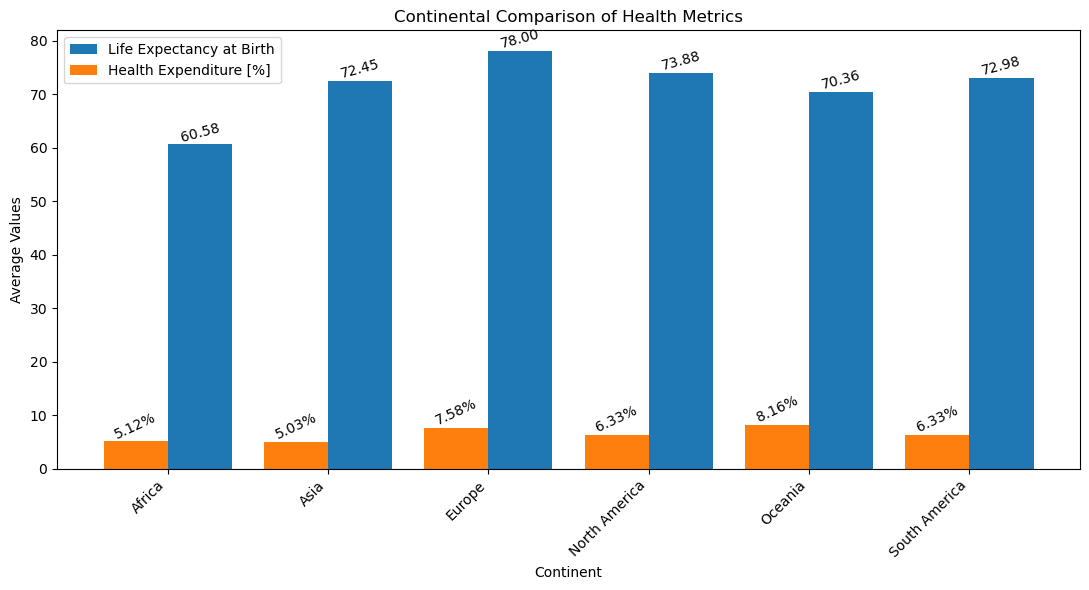

In [13]:
# Plot side-by-side bar chart of continental_avg
fig, ax = plt.subplots(figsize=(11, 6))
bar_width = 0.4
index = np.arange(len(continental_avg.index))

# Access columns by actual labels from continental_avg
life_bars = ax.bar(index + bar_width / 2, continental_avg["life_expect"], bar_width, label = "Life Expectancy at Birth")
health_bars = ax.bar(index - bar_width / 2, continental_avg["health_exp"], bar_width, label = "Health Expenditure [%]")

# Annotate each bar with its value
for bar in life_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha = "center", va = "bottom", rotation = 15)
    
for bar in health_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha = "center", va = "bottom", rotation = 25)

# Customize the plot
plt.xlabel("Continent")
plt.ylabel("Average Values")
plt.title("Continental Comparison of Health Metrics")
plt.xticks(index, continental_avg.index, rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.legend()
plt.tight_layout()

In [14]:
# Continental analysis based on mortality
continental_analysis = glbInd.groupby("continent")[['maternal_mortality', 'under_5_mortality']].sum()
continental_analysis

,maternal_mortality,under_5_mortality
continent,,
Africa,529400.0,108860.0
Asia,100853.0,30888.7
Europe,8513.0,6428.4
North America,33212.0,12005.4
Oceania,19556.0,9514.7
South America,24321.0,6463.1


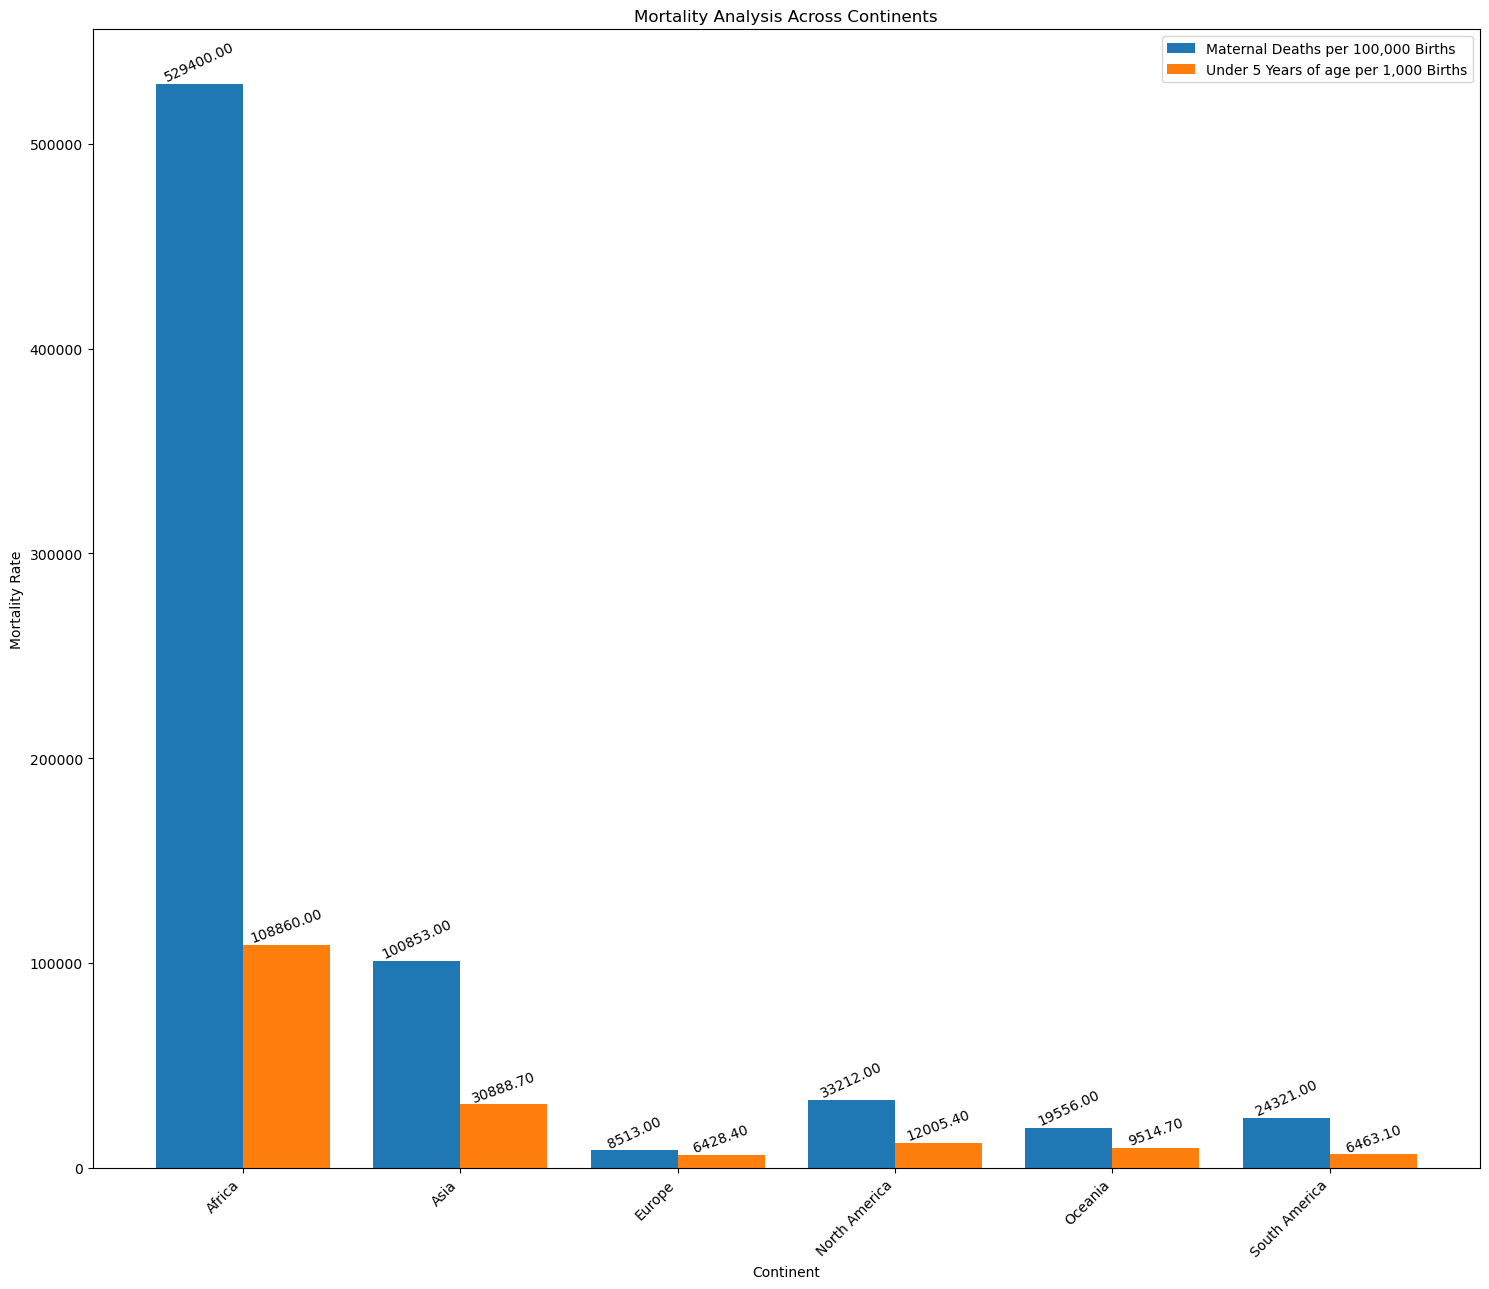

In [15]:
# Plot side-by-side bar chart of continental_analysis
fig, ax = plt.subplots(figsize=(15, 13))
bar_width = 0.4
index = np.arange(len(continental_analysis.index))

# Access columns by actual labels from continental_analysis
maternal_bars = ax.bar(index - bar_width / 2, continental_analysis["maternal_mortality"], bar_width, label="Maternal Deaths per 100,000 Births")
under_5_bars = ax.bar(index + bar_width / 2, continental_analysis["under_5_mortality"], bar_width, label="Under 5 Years of age per 1,000 Births")

# Annotate each bar with its value
for bar in maternal_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', rotation = 25)

for bar in under_5_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', rotation = 20)

# Customize the plot
plt.xlabel("Continent")
plt.ylabel("Mortality Rate")
plt.title("Mortality Analysis Across Continents")
plt.xticks(index, continental_analysis.index, rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
glbInd_new = glbInd_new.rename(columns={"health_exp": "Health Expenditure", "life_expect": "Life Expectancy", 
                                        "maternal_mortality": "Maternal Mortality", "infant_mortality": "Infant Mortality", "neonatal_mortality": "Neonatal Mortality", 
                                       "under_5_mortality": "Under 5 Mortality", "prev_hiv": "Prevalence of HIV", "inci_tuberc": "Incidence of Tuberculosis", 
                                       "prev_undernourishment": "Prevalence of Undernourishment"})
glbInd_new.head()

,Health Expenditure,Life Expectancy,Maternal Mortality,Infant Mortality,Neonatal Mortality,Under 5 Mortality,Prevalence of HIV,Incidence of Tuberculosis,Prevalence of Undernourishment
0,5.08,73.561000,5.0,3.3,2.3,4.1,0.1,12.0,2.5
2,5.08,54.846000,5.0,94.6,64.0,135.8,0.1,12.0,2.5
4,5.08,45.386000,5.0,123.5,51.0,208.0,1.3,12.0,2.5
5,5.08,75.183000,5.0,25.2,12.2,28.5,0.1,12.0,2.5
6,5.08,81.404878,5.0,6.8,3.7,8.0,0.1,12.0,2.5


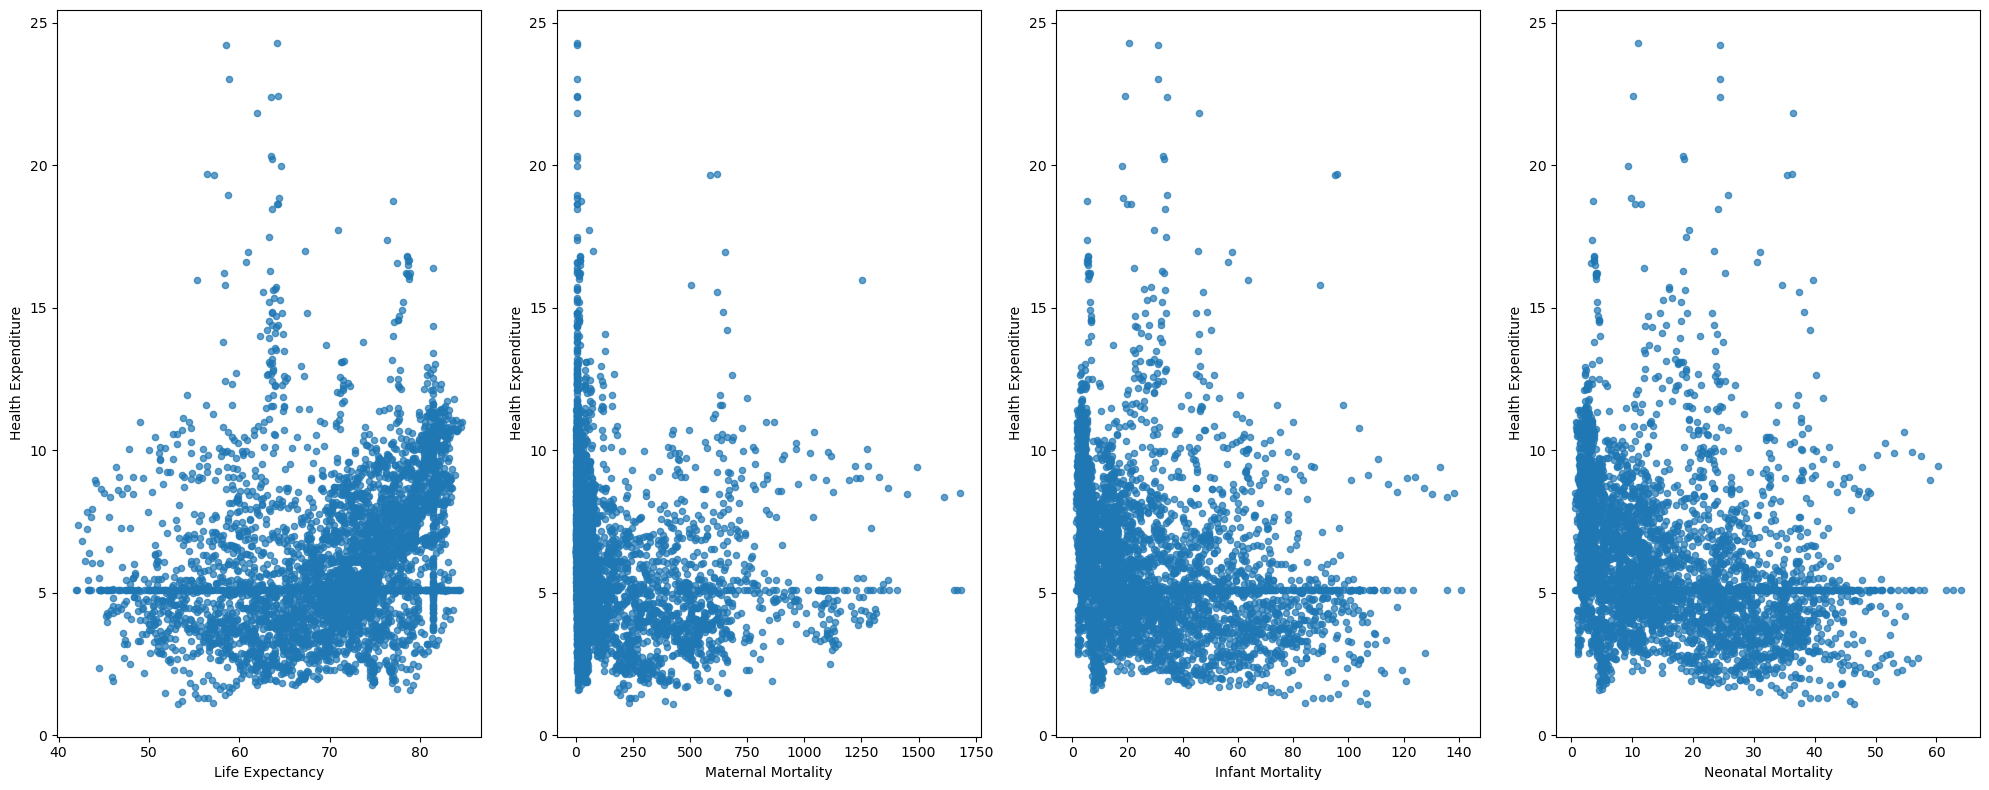

In [17]:
newglbInd = glbInd_new.drop(columns = "Health Expenditure")
# Create subplots
fig, ax = plt.subplots(1, len(newglbInd.columns[:4]), figsize = (20, 8))

# Plot scatter plots for each column against "Health Expenditure"
for i, col in enumerate(newglbInd.columns[:4]):
    glbInd_new.plot.scatter(x = col, y = "Health Expenditure", ax = ax[i], alpha = 0.7)

# Adjust layout
plt.tight_layout()
plt.show()

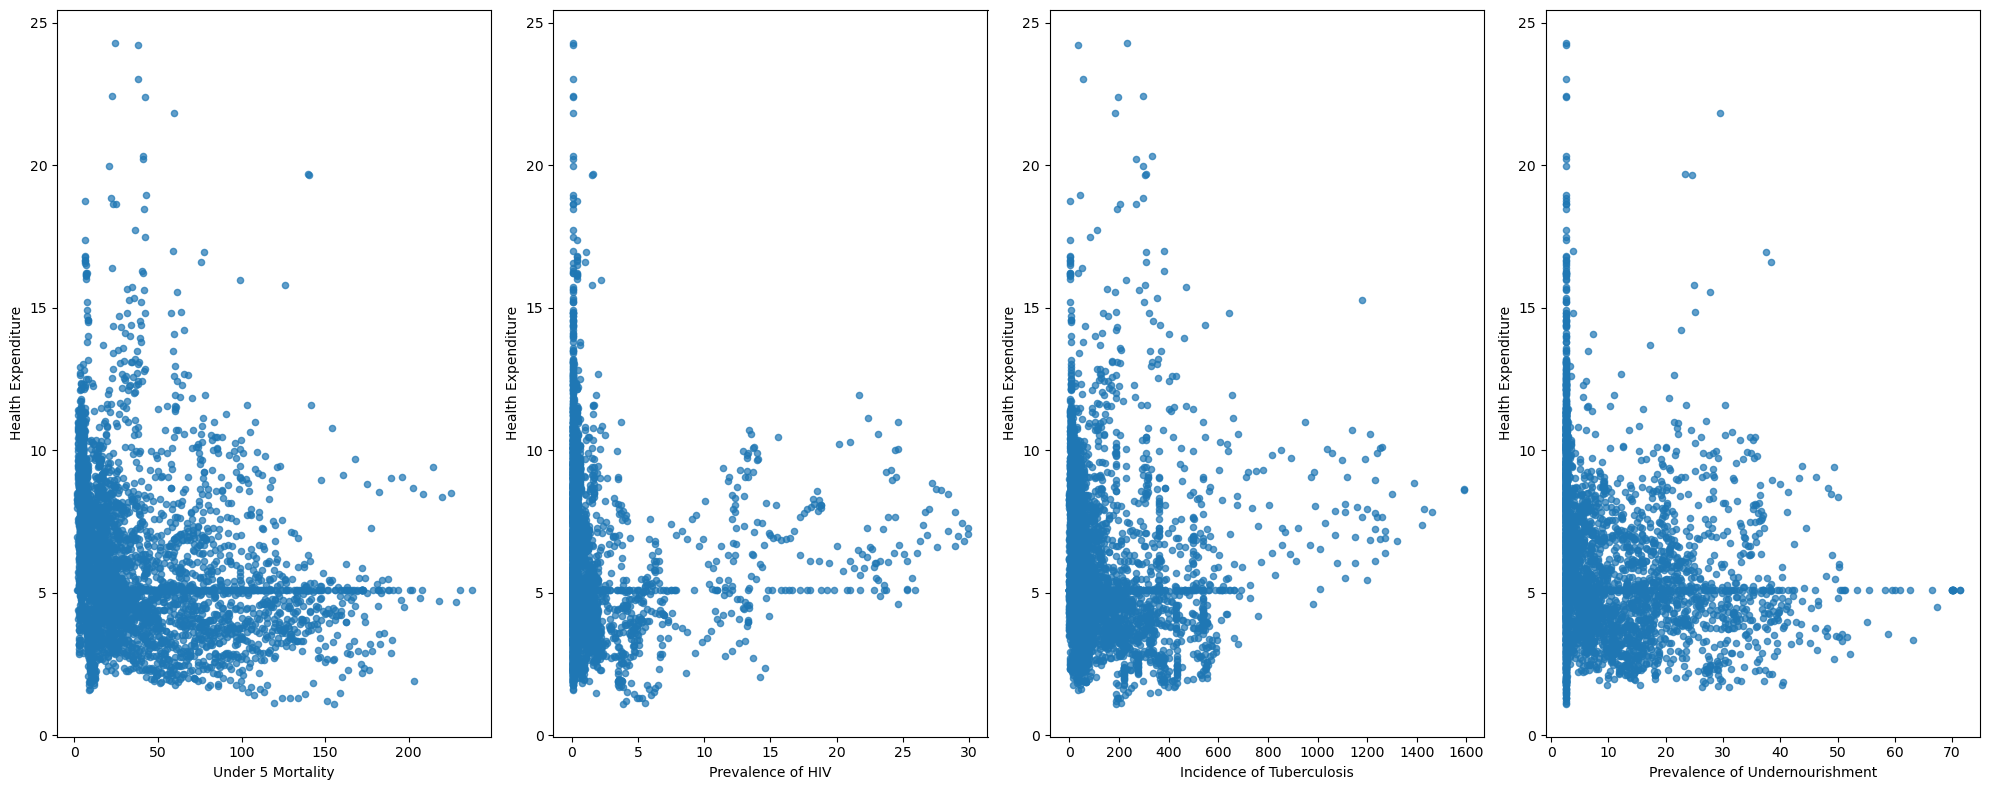

In [18]:
newglbInd = glbInd_new.drop(columns = "Health Expenditure")
# Create subplots
fig, ax = plt.subplots(1, len(newglbInd.columns[4:]), figsize = (20, 8))

# Plot scatter plots for each column against "Health Expenditure"
for i, col in enumerate(newglbInd.columns[4:]):
    glbInd_new.plot.scatter(x = col, y = "Health Expenditure", ax = ax[i], alpha = 0.7)

# Adjust layout
plt.tight_layout()
plt.show()

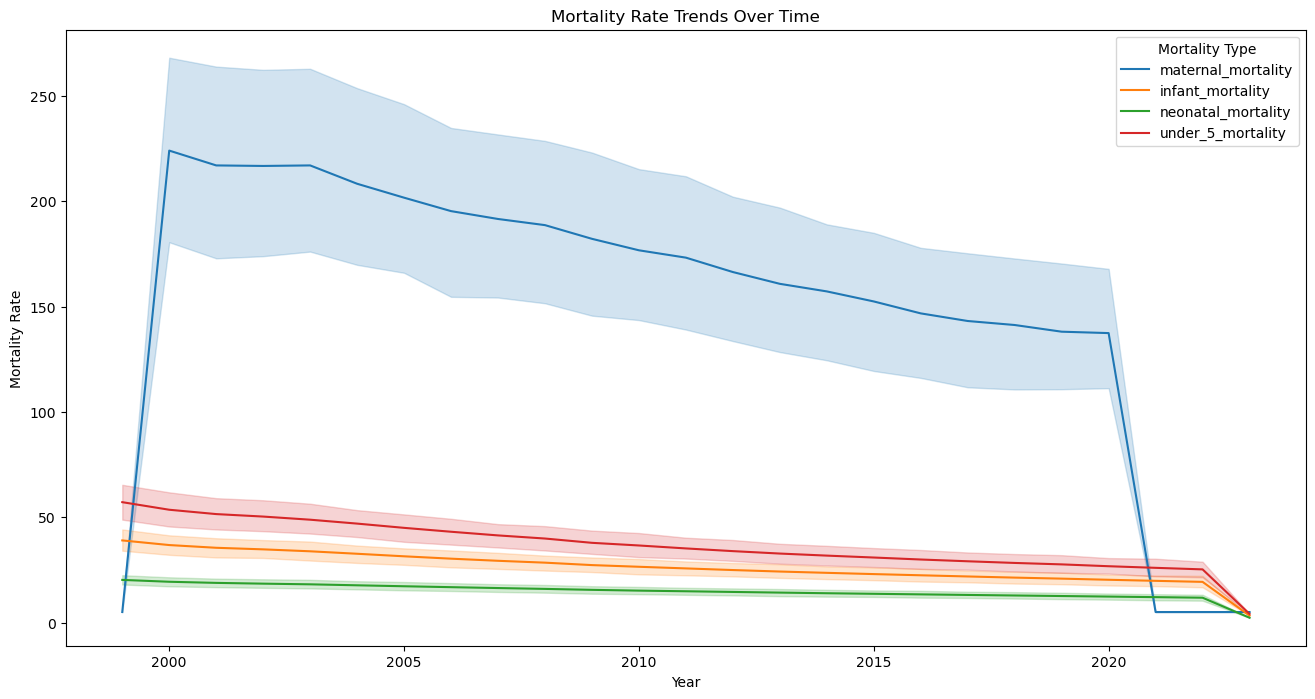

In [19]:
# Create a figure and axis for trend analysis
fig, ax = plt.subplots(figsize = (16, 8))
glbInd_trend = glbInd.melt(id_vars = ["year", "country"], 
                           value_vars = ["maternal_mortality", "infant_mortality", "neonatal_mortality", "under_5_mortality"], 
                           var_name = "Mortality Type", 
                           value_name = "Mortality Rate")

sns.lineplot(data = glbInd_trend, x = "year", y = "Mortality Rate", hue = "Mortality Type", ax = ax)
plt.title("Mortality Rate Trends Over Time")
plt.xlabel("Year")
plt.show()

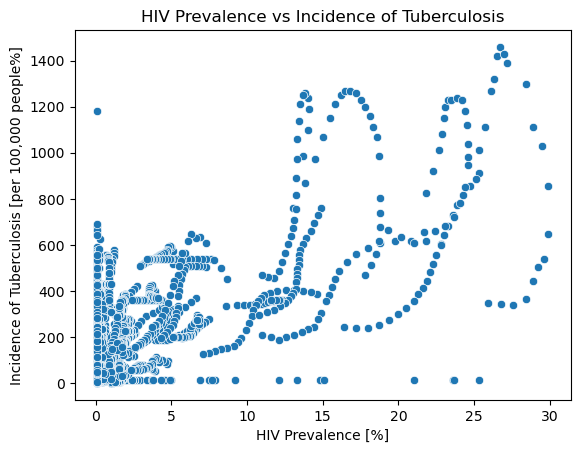

In [20]:
# Prevalence of HIV vs Tuberculosis Incidence
sns.scatterplot(data = glbInd, x = "prev_hiv", y = "inci_tuberc")
plt.title("HIV Prevalence vs Incidence of Tuberculosis")
plt.xlabel("HIV Prevalence [%]")
plt.ylabel("Incidence of Tuberculosis [per 100,000 people%]")
plt.show()

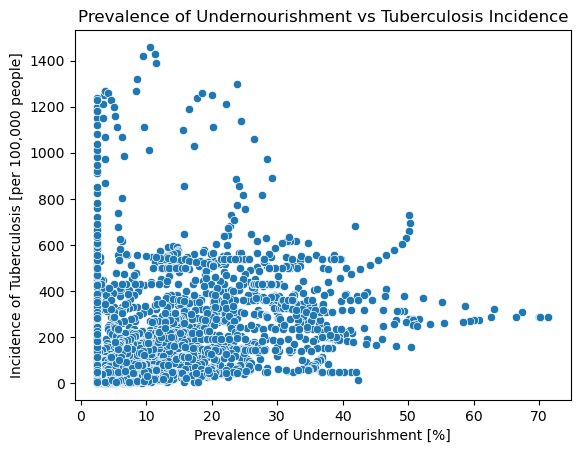

In [21]:
# Prevalence of undernourishment vs Tuberculosis Incidence
sns.scatterplot(data = glbInd, x = "prev_undernourishment", y = "inci_tuberc")
plt.title("Prevalence of Undernourishment vs Tuberculosis Incidence")
plt.xlabel("Prevalence of Undernourishment [%]")
plt.ylabel("Incidence of Tuberculosis [per 100,000 people]")
plt.show()

In [22]:
log_data = np.log1p(glbInd[["health_exp", "life_expect"]])

X = log_data
X.head()

,health_exp,life_expect
0,1.805005,4.311618
2,1.805005,4.022598
4,1.805005,3.836998
5,1.805005,4.333138
6,1.805005,4.411645


In [23]:
# Normalize the X features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Put `X_scaled` into DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled_df.head()

,health_exp,life_expect
0,-0.26161,0.384274
1,-0.26161,-1.744349
2,-0.26161,-3.111290
3,-0.26161,0.542774
4,-0.26161,1.120971


In [24]:
def sil_score(estimator, X_scaled):
    labels = estimator.fit_predict(X_scaled)
    # Check if the number of clusters is greater than 1 (required for silhouette score)
    if len(set(labels)) > 1:
        return silhouette_score(X_scaled, labels)
    else:
        return -1  # Invalid clustering case

# Instantiate the model
clus = DBSCAN()

# Define the parameter grid
params = {
    "eps": np.arange(0.5, 1.1, 0.1),  # Neighborhood size
    "min_samples": range(2, 6),   # Minimum points in a cluster
    #"leaf_size": range(15, 75, 15),
    #"p": range(2, 6)
}
# Instantiate GridSearchCV
dbscan_search = GridSearchCV(
    estimator=clus,
    param_grid=params,
    scoring=sil_score,  # Use the custom scoring function
    cv=[(slice(None), slice(None))],  # Pass-through CV for unsupervised learning
    verbose=1
)

# Fit the model
dbscan_search.fit(X_scaled)

Fitting 1 folds for each of 28 candidates, totalling 28 fits


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=DBSCAN(),
             param_grid={'eps': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
                         'min_samples': range(2, 6)},
             scoring=<function sil_score at 0x0000020E619FB920>, verbose=1)

In [25]:
dbscan_search.best_params_

{'eps': 0.5, 'min_samples': 5}

In [26]:
dbscan = DBSCAN(eps=0.5, min_samples = 5, n_jobs = 1)#(eps=0.6, leaf_size = 15, min_samples = 4, n_jobs = 1, p =2)
labels = dbscan.fit_predict(X_scaled)
dbscanScore = silhouette_score(X_scaled, labels)
print("The DBSCAN score is", round(dbscanScore, 2))

The DBSCAN score is 0.55


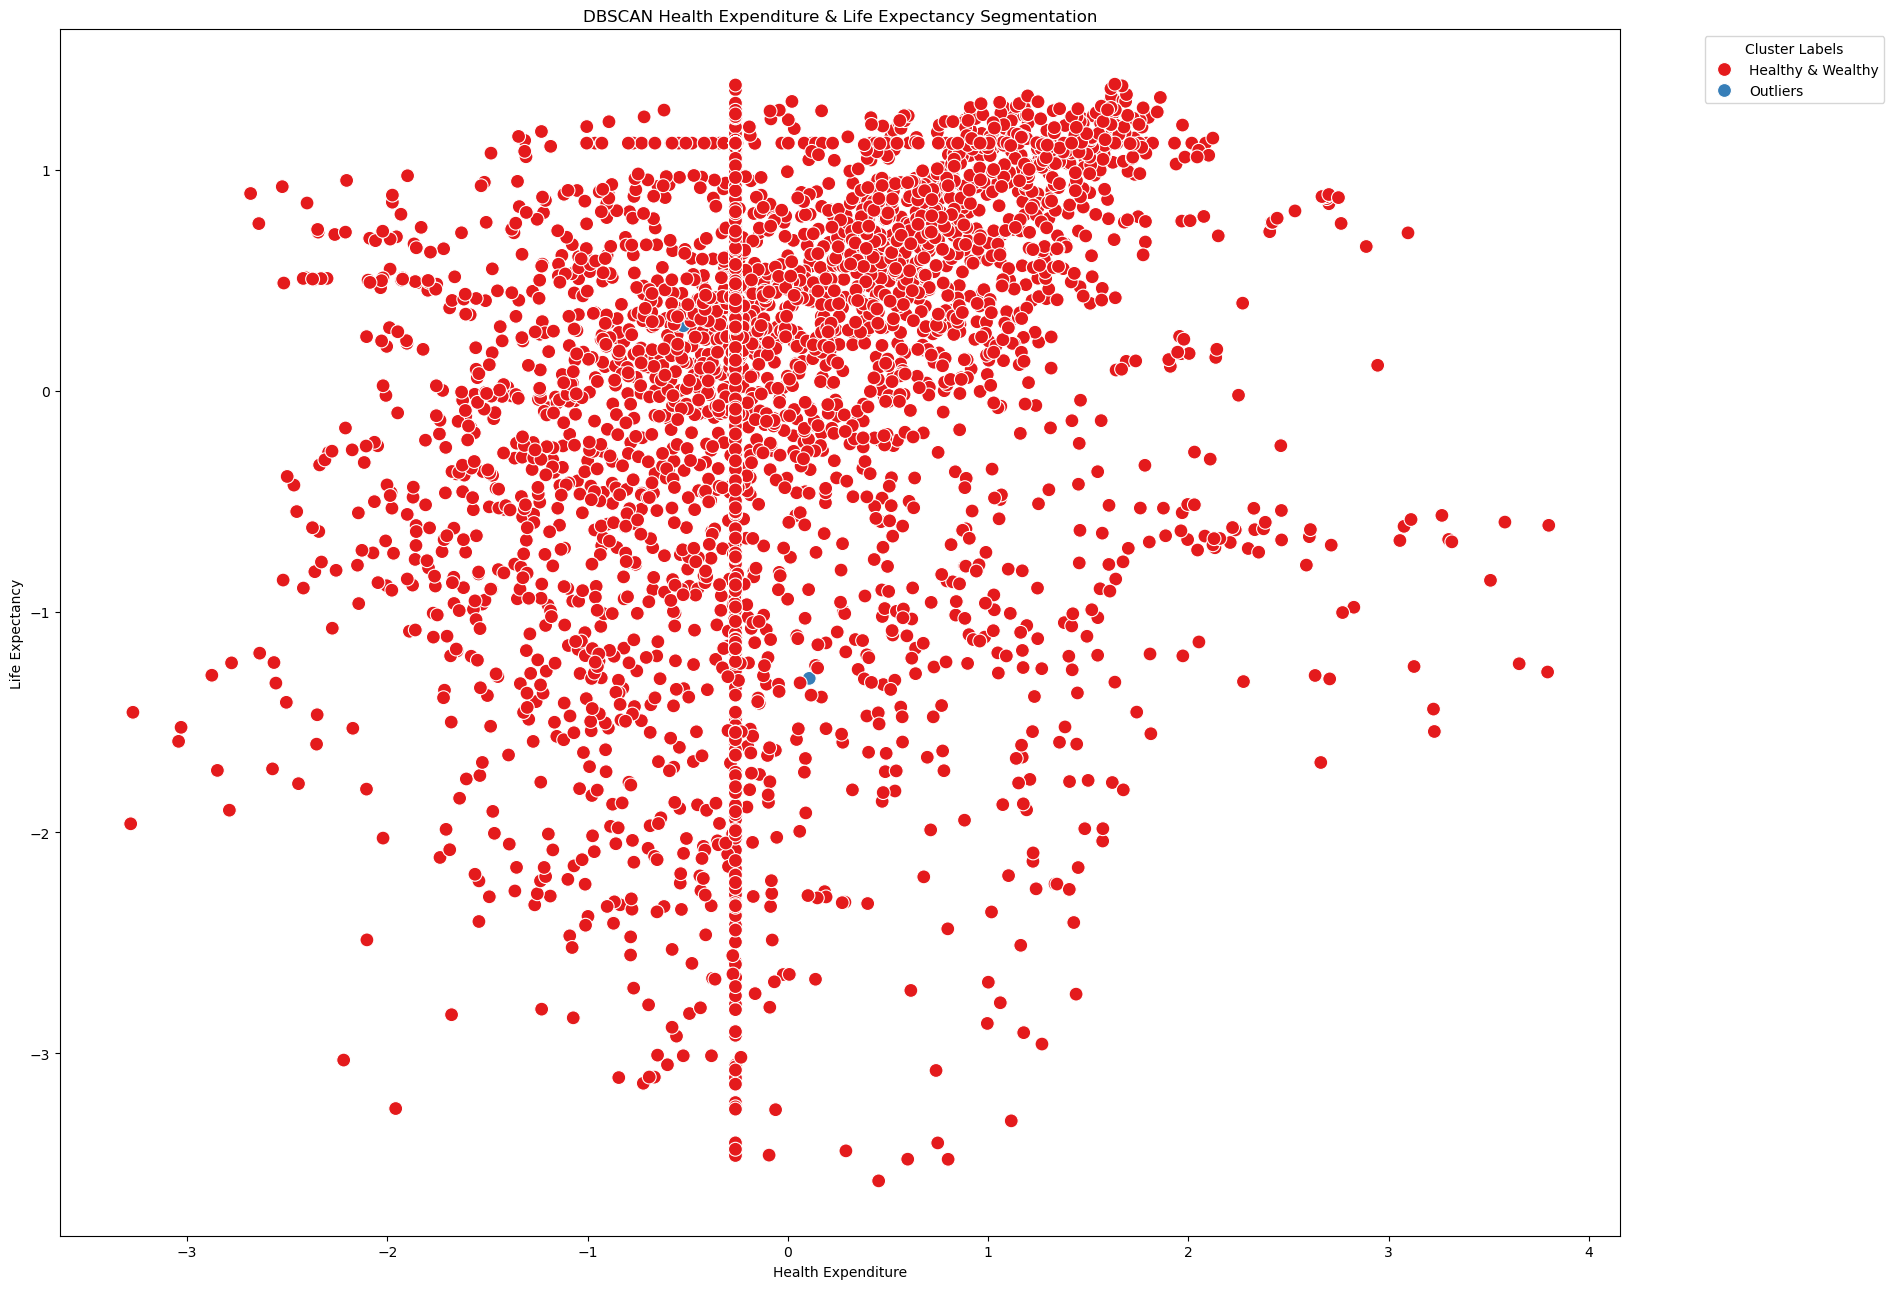

In [27]:
# Add the DBSCAN cluster labels to the original dataframe
glbInd['Cluster_Label'] = labels

# Map cluster labels to custom names
cluster_label_map = {
    -1: "Outliers",  # Noise points
    0: "Healthy & Wealthy",  # Main cluster with similar characteristics (Health Expenditure & Life Expectancy)
}

# Map the cluster labels to their respective names
glbInd['Cluster_Label_Name'] = glbInd['Cluster_Label'].map(cluster_label_map)

# Define a custom color palette for clusters
#fine_palette = ["blue", "red"]

# Create a scatterplot with cluster labels
plt.figure(figsize=(19, 13))
sns.scatterplot(
    x = X_scaled_df["health_exp"],
    y = X_scaled_df["life_expect"],
    hue = glbInd["Cluster_Label_Name"],  # Cluster labels (DBSCAN results)
    palette = "Set1",# fine_palette,
    s = 100,
    legend='full'
)

# Calculate cluster centers (centroids) for non-noise points
# Since DBSCAN doesn't have an explicit centroid, we calculate the mean of each cluster for non-noise points
cluster_centers = glbInd[glbInd["Cluster_Label"] != -1].groupby("Cluster_Label")[["health_exp", "life_expect"]].mean()

# Annotate each cluster center (excluding noise points)
for i, row in cluster_centers.iterrows():
    plt.annotate(f"Cluster {i}", (row["health_exp"], row["life_expect"]),
                 textcoords="offset points", xytext=(0, 10), ha='center')

plt.title("DBSCAN Health Expenditure & Life Expectancy Segmentation")
plt.xlabel("Health Expenditure")
plt.ylabel("Life Expectancy")

# Customize the legend title and position
plt.legend(title="Cluster Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

# Ensure everything fits on the plot
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Get the outlier countries
clusMask = glbInd["Cluster_Label"] == -1
outlier = glbInd[clusMask]
outlier.head()

,country,year,health_exp,life_expect,maternal_mortality,infant_mortality,neonatal_mortality,under_5_mortality,prev_hiv,inci_tuberc,prev_undernourishment,continent,Cluster_Label,Cluster_Label_Name
270,Angola,2000,1.908599,46.024,860.0,120.7,50.0,202.9,1.3,297.0,2.5,Africa,-1,Outliers
434,Malawi,2000,2.352475,44.518,573.0,99.6,39.1,173.4,14.6,386.0,2.5,Africa,-1,Outliers
2307,Nauru,2007,24.230680,58.530,5.0,31.1,24.5,38.2,0.1,34.0,2.5,Oceania,-1,Outliers


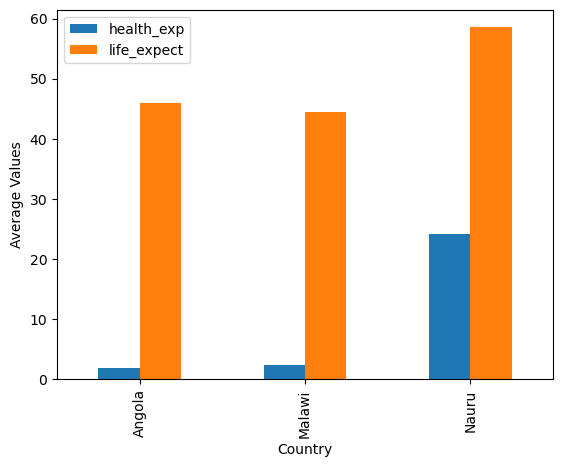

In [39]:
# Plot the outliers
outlier.groupby("country")[["health_exp", "life_expect"]].mean().plot(
    kind = "bar",
    xlabel = "Country",
    ylabel = "Average Values"
);

In [28]:
# Split data set
X = glbInd[["country", "health_exp"]]
y = glbInd[["life_expect", "maternal_mortality", "under_5_mortality", "prev_hiv", "inci_tuberc", "prev_undernourishment"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [29]:
# Get the categorical columns
cat_columns = X_train.select_dtypes("object").columns.tolist()

# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output = False, drop = "first", handle_unknown="ignore"), cat_columns)
    ],
    remainder = "passthrough"
)

# Fit the transformer on training data and transform both X_train and X_test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [30]:
# Trainning and evaluating of baseline model
mae_baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
mae_baseline = round(mae_baseline, 2)
print("The Baseline Error is", mae_baseline)

The Baseline Error is 59.49


In [31]:
# Train model
tree_model = DecisionTreeRegressor(random_state = 42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [32]:
# Evaluate the Decision Tree model
tree_predict = tree_model.predict(X_test)
tree_mae = mean_absolute_error(y_test, tree_predict)
tree_mae = round(tree_mae, 2)

print(f"The Decision Tree Regressor Model MAE is {tree_mae} with a {round(mae_baseline - tree_mae, 2)} reduction compare to the baseline")

The Decision Tree Regressor Model MAE is 15.89 with a 43.6 reduction compare to the baseline
